# Processing Tasks With Stacks and Queues


## Assigning Tasks to Pools

In the last course, we talked about the idea of worker pools. We used assigning documents to translators as an example. You have a "pool" of several translators who are waiting for work. As the work comes in, it gets assigned to free translators, who then complete the translation work. This model works well when you have a fixed amount of work, or when you have more translators than available work. Here's an example with a fixed amount of work:

![fixed-amount-of-work](https://s3.amazonaws.com/dq-content/168/translators_2.svg)

But what happens when work is constantly coming in? Let's say that you're writing some code for the [Department Of Motor Vehicles](https://en.wikipedia.org/wiki/Department_of_Motor_Vehicles), or DMV, in [California](https://en.wikipedia.org/wiki/California). If you're unfamiliar, the DMV in America handles driver's license issuances and renewals. In order to apply for a driver's license, you need quite a bit of information, including:
* Your name
* Your address
* Your [Social Security Number](https://en.wikipedia.org/wiki/Social_Security_number)

A single DMV office is usually open between 9am and 5pm. During these hours, people come in, and give their application information to clerks. These clerks then collate the application information and file it for further processing. After the processing is done, the license is able to be printed and given to the applicant.<br>

Let's say that the code you're writing needs to handle this further processing, and your system can handle processing `200` applications per hour. Throughout the day, the DMV handles a variable number of visitors:

![app-count-during-the-day](https://s3.amazonaws.com/dq-content/172/visitors_during_day_1.svg)

As you can see, there are times during the day when you're below processing capacity (green), times when you're at capacity (blue) and times when you're above capacity (red). This means that not everyone will get their application processed immediately. When we can't process applications immediately, we put them in a backlog to process later. We can look at backlog length by hour to get a better sense of this:

![backlog-length-during-the-day](https://s3.amazonaws.com/dq-content/172/queue_length_during_day_1.svg)

As you can see, backlog length generally increases throughout the day. Whenever the backlog length is greater than `0`, it means that people coming in may have to wait for a while in order to get their license. Note that because your computer system works 24/7, any applications that are unprocessed at the end of the day will finish being processed overnight.<br>

**There's one simple strategy for dealing with the backlog -- we just process people's applications in the order they were added to the backlog**. This works like a traditional line -- if you're the first person in line, your application is processed first, and if you're the last person, your application gets processed last. Because the DMV has a small waiting area, they don't want tons of people waiting for their licenses. So if they can't guarantee that your applicant will be processed immediately, they ask you to come back the next day to pick up your license.<br>

This means that the clerks at the DMV would tell everyone to come back the next morning if there's any kind of backlog. For example, if there are `50` applications in the backlog, and you just submitted your application, there wouldn't be a guarantee of your task being processed immediately, so you'd have to come back later. Here's how this strategy would look:

![backlog-strategy-flow](https://s3.amazonaws.com/dq-content/172/processing_with_queue.svg)

As you can see above, we add new applications to the end of the line, or the "bottom", and we pull applications to process from the start of the line, or the "top".<br>

There's another, more complex, strategy that may lead to better customer outcomes. In the alternate strategy, you process applications as soon as they come in, ignoring what's already in the backlog. So if there are `50` applications in the backlog already, a new application will be prioritized ahead of them if it was just submitted. This means that some percentage of people during busy times will immediately get their applications processed, while everyone else will have to come back the next day. This theoretically is better for customers than the alternative, as some are able to get their application processed more quickly:

![alternative-backlog-strategy](https://s3.amazonaws.com/dq-content/172/processing_with_stack.svg)

As you can see above, we add new applications to the start of the line, or the "top", and we pull applications to process from the start of the line as well.<br>

Both of the task prioritization paradigms we mentioned above are used extensively in computer science. The first is known as the queue, and the second is known as the stack. In this mission, we'll expand on queues and stacks, and go into more depth about how and when each model is useful.<br>

Before we do so, here's a diagram of a stack:

![diagram-stack](https://s3.amazonaws.com/dq-content/172/Lifo_stack.png)

And here's a diagram of a queue:

![diagram-queue](https://s3.amazonaws.com/dq-content/172/fifo_queue.png)





## Processing Applications

In this mission, we'll use a dataset of applications for driver's licenses. Due to the sensitivity of the fields, we're using randomly generated data. You can look at `generate_data.py` in this same folder for a peek at how the generation was done. The applications are stored in `application.csv`, and each application contains the following fields:
* `name` -- the first and last name of the applicant.
* `address` -- the current address of the applicant.
* `previous_address` -- the previous address of the applicant.
* `gender` -- the gender of the applicant.
* `ssn` -- the social security number of the applicant.
* `birthdate` -- the date of birth of the applicant.
* `job` -- a description of the applicant's job.
* `phone` -- the applicant's phone number.

There are `2400` applications to process altogether. To keep things simple, we're assuming that `300` applications come in every hour, and since there are 8 hours between `9am` and `5pm`, that gives us `2400` total applications to process.<br>

Here are the first `5` rows of `applications.csv`:

In [1]:
import pandas as pd
applications = pd.read_csv('../data/applications.csv')
applications.head()

,name,address,previous_address,gender,ssn,birthdate,job,phone
0,Johnny Baker,1998 Cook Street Friedmanfurt CA 95687,158 Mccoy Key Port Maurice WY 72503-8242,M,548-22-4499,1924-12-29 11:06:29,Magazine journalist,1-410-888-3602
1,Shirley Nelson,06031 Donna Fields East Vanessa CA 94770,885 Adams Rapids Victorburgh ME 42614-9327,F,685-92-4500,1988-03-29 06:32:25,Adult nurse,1-254-662-2625
2,Patrick Morrison,133 Earl Plains East Stevenstad CA 90480,0251 Luna Hill Apt. 201 South Kennethport ID ...,M,899-18-8813,1962-03-28 20:19:51,Solicitor,1-590-376-7820x3438
3,Benjamin Andrews,9988 Micheal Lock Suite 298 Kirbyberg CA 95232,1308 Ramirez Manors Suite 981 North James NC ...,M,214-61-7418,1942-08-15 16:33:22,Tourist information centre manager,(905)117-2921
4,Alan Preston,8759 Woods Loaf New Maryview CA 92517,969 Andrew Bypass Suite 567 Mcdonaldtown LA 7...,M,273-75-2787,1938-01-05 17:37:32,Building surveyor,317-539-2094x159


Before we look into how to use stacks and queues to prioritize tasks, let's write a function that processes a single application. The function will need to take in a single applicant, then:
* Verify that they're at least `18` years old.
* Verify that they live in California (abbreviated as `CA` in the `address` column).

We've read `applications.csv` into a pandas DataFrame called `applications`.

* Write a function called `process_application` to perform the age and address verifications mentioned earlier for a single applicant.
  * Age check
    * Verify that the applicant is at least `18`.
    * To make the age check easier, let's assume every year has `365.25` days.
  * Residence check
    * Verify that the applicant lives in `CA`.
  * The function should return `True` if the applicant passes both verifications, and `False` if they failed one.
* Run the function over every applicant.
* Assign the result to `application_status`.
  * Ensure that `application_status` is a list of Boolean values.

In [2]:
applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 8 columns):
name                2400 non-null object
address             2400 non-null object
previous_address    2400 non-null object
gender              2400 non-null object
ssn                 2400 non-null object
birthdate           2400 non-null object
job                 2400 non-null object
phone               2400 non-null object
dtypes: object(8)
memory usage: 150.1+ KB


In [3]:
applications.columns.tolist()

['name',
 'address',
 'previous_address',
 'gender',
 'ssn',
 'birthdate',
 'job',
 'phone']

In [4]:
# investigate data string format
applications['address'][:5]

0            1998 Cook Street Friedmanfurt CA 95687
1          06031 Donna Fields East Vanessa CA 94770
2          133 Earl Plains East Stevenstad CA 90480
3    9988 Micheal Lock Suite 298 Kirbyberg CA 95232
4             8759 Woods Loaf New Maryview CA 92517
Name: address, dtype: object

In [5]:
applications['birthdate'][:5]

0    1924-12-29 11:06:29
1    1988-03-29 06:32:25
2    1962-03-28 20:19:51
3    1942-08-15 16:33:22
4    1938-01-05 17:37:32
Name: birthdate, dtype: object

In [6]:
import time
from datetime import datetime
from dateutil import parser

In [7]:
def process_application(row):
    
    # verify age
    now = parser.parse(time.strftime("%c"))
    timedelta_days = (now - parser.parse(row['birthdate'])).days
    timedelta_years = timedelta_days / 365.25
    age_verification = (timedelta_years >= 18)
    
    if not age_verification:
        return False
    
    # verify residence
    residence_verification = (row['address'][-8:-6] == 'CA')
    
    if not residence_verification:
        return False
    
    return True

In [8]:
application_status = applications.apply(process_application, axis=1)

In [9]:
# Every application meets the requirement

print(len(application_status))
print(sum(application_status))

2400
2400


## Stacks

A stack is a data structure that takes in new elements at the "top". When you want to access an element, it is also removed from the top. This is known as "last-in-first-out" queue, since the last element put into the stack is the first element taken out.

![Stack-Operations](https://s3.amazonaws.com/dq-content/172/stack_operations_1.svg)

As you can see, we add element `3` to the top, then add element `4` to the top. We then remove element `4` from the top. We can simulate this with the Python [list.insert](https://docs.python.org/3/tutorial/datastructures.html) and [list.pop](https://docs.python.org/3/tutorial/datastructures.html) methods. We'll start with a list that contains elements `1` and `2`:

```bash
>> stack = [1,2]
>> stack
[1,2]
```

We then add element `3` to the "top" of the stack:

```bash
>> stack.insert(0,3)
[3,1,2]
```

We then add `4` to the top of the stack:

```bash
>> stack.insert(0,4)
>> stack
[4,3,1,2]
```

We can then remove the "top" element of the stack:
```bash
>> stack.pop(0)
4
>> stack
[3,1,2]
```

We're considering the beginning of the list to be the "top" of our stack, and the end of the list to be the "bottom". This, when we add elements using `insert`, we add them at index `0`, or the beginning. We also remove elements from index `0`, or the beginning, using `pop`.<br>

A stack is a way to implement the theoretically more efficient method of prioritization we discussed in the first screen. In this example, applications would be added to the top of the backlog as they're submitted. We'd then remove tasks from the top of the stack to process them. Let's profile how a stack would perform if it was processing the data for the DMV. We can do this by:

* Creating a stack.
* Creating one thread to add tasks to the stack.
* Creating a second thread to remove tasks from the stack and process them.
* Keeping track of wait time for each task:
  * If the task was put on the stack and immediately removed and processed, let's say the wait time is `10` minutes.
  * If the task had to wait for another task to process first, the applicant has to come back the next morning at `9am`. To keep things simple, let's say that `300` applications are added to the backlog every hour, and that applications start coming in at `9am`. Thus, the first `300` applications (from `1` to `300`) would have to wait `23` hours (from `10am` to `9am` the bext day). Applications throughout the day would have to wait:
    * `301-600` -- `22` hours.
    * `601-900` -- `21` hours.
    * `901-1200` -- `20` hours.
    * `1201-1500` -- `19` hours.
    * `1501-1800` -- `18` hours.
    * `1801-2100` -- `17` hours.
    * `2101-2400` -- `16` hours.
    
We can compute wait time with the following method:
* Create a list to store the wait times.
* When adding tasks:
  * Store the task number in the stack, along with the application data.
  * Keep track of the task numbers added to the stack in a separate list.
* When processing tasks:
  * If the last task added to the stack is being processed, add 10 minutes to the total wait time.
    * Find this by comparing the latest task number to the task number of the application being processed.
  * If the last task is not being processed, calculate the wait time based on the task number.

By averaging the wait time across all applications, we can figure out how efficient it is to prioritize our DMV applications using a stack.

* Create a list called `wait_times` to store the wait times.
* Create a list called `stack` to store the tasks.
* Create a list called `task_numbers` to store the task numbers of the tasks added to `stack`.
* Create a function, `add_tasks`, to add tasks to the stack. The function should loop through `applications`, and:
  * Individually add rows to `stack`, along with the task numbers, in a single tuple. The task number is the pandas row index with `1` added to it. (the row index starts at `0`, but task numbers start at `1`, so we need to add `1`)
    * Here's how this should look in code: `stack.insert(0,(index + 1, row))`
  * Append the task number to `task_numbers` whenever an item is added to stack.
  * Sleep for `.001` seconds.
* Create a function, `process_tasks`, to process tasks. The function should:
  * Check if `stack` is empty. If it is, wait for a second.
  * If `stack` is not empty, remove the first task from `task`, and process the task using `process_application`.
  * Compute the wait time for this task, and append to `wait_times`.
    * If the task number matches the last number in `tasks`, the wait time is `10` minutes.
    * If not, you'll need to compute it based on the task number.
* Start two threads, one for each function, and wait until they finish executing.
* Find the average wait time, in seconds, and assign to `average_wait_time`.
* Inspect wait_times to see how the wait time changed as more tasks were processed.
* Try varying the sleep times in the `process_application` and `add_tasks` functions. Does this change the average wait time? Why do you think this is happening?

In [10]:
import threading
import math

In [11]:
wait_times, stack, task_numbers = [], [], []

def add_tasks(sleep_time=.001):
    
    for i, row in applications.iterrows():
        
        stack.insert(0, (i+1, row))
        task_numbers.append(i+1)
        time.sleep(sleep_time)


In [12]:
def process_tasks(sleep_time_nostack=1,
                 sleep_time_finaltask=600):
    tasks_finished = 0
    
    while tasks_finished < 2400:
        
        if len(stack) == 0:
            time.sleep(sleep_time_nostack)
        
        else:
            task_number, application = stack.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            
            if task_number == task_numbers[-1]:
                wait_times.append(sleep_time_finaltask)
            
            else:
                wait_times.append((24 - math.ceil(task_number / 300)) * 3600)
    

In [19]:
def test_and_get_avg_time(add_task_wait_time,
                         process_tasks_wait_time1,
                         process_tasks_wait_time2):
    
    t1 = threading.Thread(target=add_tasks,
                         args=(add_task_wait_time,))
    t2 = threading.Thread(target=process_tasks,
                         args=(process_tasks_wait_time1,
                              process_tasks_wait_time2))

    t1.start();t2.start();t1.join();t2.join()

    average_wait_time = sum(wait_times)/2400
    print('add_task wait time: {}\nprocess_tasks wait time(1): {}\nprocess_tasks wait time(2): {}'.\
              format(add_task_wait_time,
                    process_tasks_wait_time1,
                    process_tasks_wait_time2))
    print('AVG time: {}'.format(average_wait_time))
    
    return wait_times
    

In [21]:
# default wait time
wait_times, stack, task_numbers = [], [], []
test_and_get_avg_time(.001, 1, 600)
print('')

add_task wait time: 0.001
process_tasks wait time(1): 1
process_tasks wait time(2): 600
AVG time: 66667.25



In [22]:
from matplotlib import pyplot as plt

test_timeset = [(.001, 10, 6000),
               (.001, 1, 600),
               (.001, .1, 60),
               (.001, .01, 6)]

avg_wait_times = []

for tt in test_timeset:
    wait_times, stack, task_numbers = [], [], []
    avg_wait_times.append(test_and_get_avg_time(tt[0], tt[1], tt[2]))
    print('#'*30)


add_task wait time: 0.001
process_tasks wait time(1): 10
process_tasks wait time(2): 6000
AVG time: 70146.5
##############################
add_task wait time: 0.001
process_tasks wait time(1): 1
process_tasks wait time(2): 600
AVG time: 66790.5
##############################
add_task wait time: 0.001
process_tasks wait time(1): 0.1
process_tasks wait time(2): 60
AVG time: 64929.025
##############################
add_task wait time: 0.001
process_tasks wait time(1): 0.01
process_tasks wait time(2): 6
AVG time: 60126.86
##############################


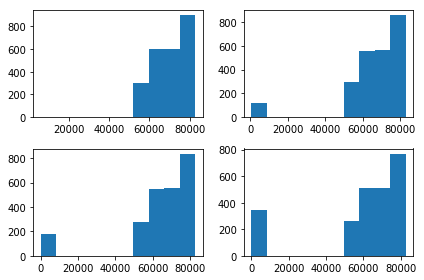

In [31]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.hist(avg_wait_times[0])

ax2 = fig.add_subplot(222)
ax2.hist(avg_wait_times[1])

ax3 = fig.add_subplot(223)
ax3.hist(avg_wait_times[2])

ax4 = fig.add_subplot(224)
ax4.hist(avg_wait_times[3])

plt.tight_layout()
fig = plt.gcf()
plt.show()

In [35]:
test_timeset = [(.01, 1, 600),
                (.001, 1, 600),
                (.0001, 1, 600),
                (.00001, 1, 600)]

avg_wait_times = []

for tt in test_timeset:
    wait_times, stack, task_numbers = [], [], []
    avg_wait_times.append(test_and_get_avg_time(tt[0], tt[1], tt[2]))
    print('#'*30)

add_task wait time: 0.01
process_tasks wait time(1): 1
process_tasks wait time(2): 600
AVG time: 67657.0
##############################
add_task wait time: 0.001
process_tasks wait time(1): 1
process_tasks wait time(2): 600
AVG time: 66747.5
##############################
add_task wait time: 0.0001
process_tasks wait time(1): 1
process_tasks wait time(2): 600
AVG time: 70142.0
##############################
add_task wait time: 1e-05
process_tasks wait time(1): 1
process_tasks wait time(2): 600
AVG time: 70142.0
##############################


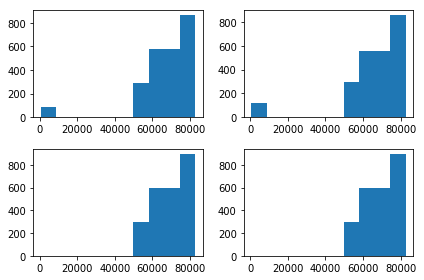

In [36]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.hist(avg_wait_times[0])

ax2 = fig.add_subplot(222)
ax2.hist(avg_wait_times[1])

ax3 = fig.add_subplot(223)
ax3.hist(avg_wait_times[2])

ax4 = fig.add_subplot(224)
ax4.hist(avg_wait_times[3])

plt.tight_layout()
fig = plt.gcf()
plt.show()

## Implementing A Stack

Although we used the Python list implementation as a stack in the last screen, it can be helpful to implement your own stack. This allows you to store custom values, avoid mistakes when adding removing elements, and add additional methods. A good use case for a stack is as a shared way to distribute tasks or store values when you're working across multiple threads. As you work with larger datasets, custom implementations become more necessary. The easiest way to implement a stack is to create a custom class. The class needs two methods at the minimum:
* `push` -- adds a value to the stack.
* `pop` -- removes a value from the stack.

Additionally, the stack needs an internal list to store the values in the stack:
* `items` -- a list of all the items in the stack.

Implementing `push` and `pop` is very similar to what you did when adding and removing elements from `stack` in the last screen.<br>

We're implementing a custom class on top of a list for a few reasons:
* It's easier to implement a stack this way, and learn how stacks work, than it is to implement a completely custom stack.
* Implementing a stack class instead of using a list makes adding and removing much simpler, since you don't need to remember which index to pass into the list.

We can easily add custom methods on top of the stack.

* Create a class called `Stack` that:
  * Uses an instance variable called `items` to store the stack values.
  * Has a `push` method to add values to the stack, and a `pop` method to remove values from the stack.
  * Has a `count` method to count the number of values in the stack.
* Instantiate an instance of `Stack` called `stack`.
* Add `1`, `2`, and `3` to `stack`.
* Remove an element from `stack`.

In [15]:
class Stack():
    
    def __init__(self):
        self.items = []
        
    def push(self, value):
        self.items.insert(0, value)
        
    def pop(self):
        return self.items.pop(0)
        
    def count(self):
        return len(self.items)
    
stack = Stack()
stack.push(1)
stack.push(2)
stack.push(3)
stack.pop()
    

3

In [16]:
stack.items

[2, 1]

In [17]:
stack.count()

2

## Time Spent in Stacks

We can vary a few different parameters, which will change the average wait time with our stack:
* How we compute wait time (should we compute it as a binary value -- either you wait a day or you don't?)
* How quickly tasks are added to the stack
* How quickly tasks on the stack are processed

### If the capacity to process tasks is higher than the rate of tasks coming in, the wait time will always be the lowest possible amount. 
### If tasks are added more quickly than they can be processed, there's an advantage to using stacks, since some people get their licenses much more quickly. 

This should have been evident from the experimentation you did with sleep times a few screens ago.<br>

Let's see how a stack would perform if we adjust how we define wait time. Let's say that applicants are happy to sit in the DMV lobby indefinitely. Let's compute wait time by assuming that each application takes `20` seconds to process. Thus, how long an application takes to process depends on how many applications were processed after it was added to the queue. The formula is `20 * application_count + 600`. We add 600 to represent the time it takes to print the licenses -- it's a constant number.<br>

We can keep track of the number of applications processed before an application by using a counter. We can do this by:
* Creating a list called `queue_time`.
* Appending a `0` to `queue_time` whenever a task is placed onto the stack. The task number of the task minus one is equal to the index of the task in `queue_time`. If we want to look up how many tasks have been processed before a given task, we look up `queue_time[task_number - 1`].
* When a task is processed, look up its corresponding entry in `queue_time` to get the number of applications processed before it.
* When a task is processed, add `1` to every entry in `queue_time` to indicate the tasks that were processed before it.

Here's a diagram:

![stack-diagram](https://s3.amazonaws.com/dq-content/172/queue_times.svg)

Note that we add `1` to every element in `queue_times` for convenience. This gives us accurate queue times at the time that we lookup the queue time for an index (for example, when we process `3`, the queue time is `0`, when we process `2`, the queue time is `1`, and when we process `1`, the queue time is `2`). We look up the queue time by using the task number minus `1` to index `queue_times`.<br>

Note that only Python objects can be modified across threads, so we need to use the following code to increment all of the values in `queue_times`:

```python
for i in range(len(queue_times)):
    queue_times[i] += 1
```

* Create a list called `queue_times` -- we'll store the number of applications processed before each application in this.
* Create a list called `wait_times`.
* Either use your custom `Stack` class, or create a list called `stack`.
* Modify `add_tasks`:
  * Append `0` to `queue_times` every time a task is added to `stack`.
* Modify `process_tasks`:
  * Look up the queue time from the `queue_times` list.
  * Calculate `wait_time` based on the queue time, and append to `wait_times`.
  * Increment all of the values in `queue_times` using the code provided earlier.
* Run both threads like you did in an earlier screen.
* Compute the average wait time and assign to `average_wait_time`.
* Inspect the value of `average_wait_time`. Is it what you expected? Does the number surprise you at all?
* Experiment with changing the sleep times in `add_tasks` and `process_tasks`. What happens?
* Plot a histogram of `wait_times` using [matplotlib](http://matplotlib.org/).

In [41]:
queue_times, wait_times, stack = [], [], []

In [38]:
def add_tasks(sleep_time):
    for index, row in applications.iterrows():
        stack.insert(0,(index + 1, row))
        
        queue_times.append(0)
        
        time.sleep(sleep_time)


def process_tasks(sleep_time):
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(stack) == 0:
            time.sleep(sleep_time)
        else:
            task_number, application = stack.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            
            wait_time = queue_times[task_number - 1] * 20 + 600
            wait_times.append(wait_time)
            
            for i in range(len(queue_times)):
                queue_times[i] += 1

                
t1 = threading.Thread(target=add_tasks, args=(.001,))
t2 = threading.Thread(target=process_tasks, args=(1,))

t1.start()
t2.start()
for t in [t1,t2]:
    t.join()

average_wait_time = sum(wait_times) / 2400
print(average_wait_time)

6253.65


In [42]:
# experiment with different sleep times
# update the function for testing

def test_and_get_avg_time(add_task_wait_time,
                         process_tasks_wait_time):
    
    t1 = threading.Thread(target=add_tasks,
                         args=(add_task_wait_time,))
    t2 = threading.Thread(target=process_tasks,
                         args=(process_tasks_wait_time,))

    t1.start();t2.start();t1.join();t2.join()

    average_wait_time = sum(wait_times) / len(applications)
    print('add_task wait time: {}\nprocess_tasks wait time: {}'.\
              format(add_task_wait_time,
                    process_tasks_wait_time))
    print('AVG time: {}'.format(average_wait_time))
    
    return wait_times

In [43]:
test_times = [(.001, 10),
             (.001, 1),
             (.001, .1),
             (.001, .01)]

avg_wait_times = []

for tt in test_times:
    queue_times, wait_times, stack = [], [], []
    avg_wait_times.append(test_and_get_avg_time(tt[0], tt[1]))


add_task wait time: 0.001
process_tasks wait time: 10
AVG time: 24570.008333333335
add_task wait time: 0.001
process_tasks wait time: 1
AVG time: 6178.95
add_task wait time: 0.001
process_tasks wait time: 0.1
AVG time: 1201.0416666666667
add_task wait time: 0.001
process_tasks wait time: 0.01
AVG time: 661.2083333333334


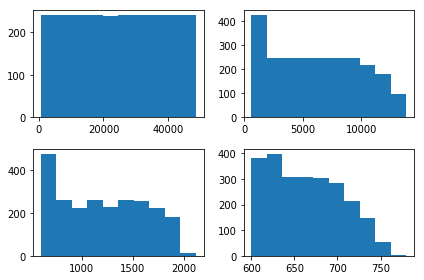

In [44]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.hist(avg_wait_times[0])

ax2 = fig.add_subplot(222)
ax2.hist(avg_wait_times[1])

ax3 = fig.add_subplot(223)
ax3.hist(avg_wait_times[2])

ax4 = fig.add_subplot(224)
ax4.hist(avg_wait_times[3])

plt.tight_layout()
fig = plt.gcf()
plt.show()

## Waiting Time With Queues

In the last screen, **you saw how we reduced wait time by having people wait around until their licenses were processed**. The histogram of the wait times should have looked something like this:

![histogram-wait-times](https://s3.amazonaws.com/dq-content/172/wait_time_hist.png)

As you can see above, the majority of people waited for less than `5000` seconds, or about `1.5` hours. However, a few people kept getting their applications pushed to the back of the stack, and thus had to wait for `10` hours or more. If the priority was to get the majority of people their licenses as quickly as possible, using a stack was a success. **However, we should see if we can make the experience better for everyone, and reduce the maximum wait time to less than `10` hours**.<br>

One way to do this might be to prioritize tasks using a queue instead of a stack. We discussed queues in the first screen of the mission -- a queue is a first in first out system, where the tasks who arrived first get processed first:

![using-queues](https://s3.amazonaws.com/dq-content/172/queue_operations_1.svg)

As you can see, a queue is similar to a traditional line, where things are processed in the order they arrived. Similarly to a stack, we can also simulate a queue using a Python list. We'll start with a list that contains elements `1` and `2`:

```python
>> queue = [1,2]
>> queue
[1, 2]
```

We then add element `3` to the bottom of the queue:

```python
>>> queue.append(3)
>>> queue
[1,2,3]
```

We then add `4` to the bottom of the queue:

```python
>>> queue.append(4)
>>> queue
[1,2,3,4]
```

We can then remove the top element of the queue:
```python
>> queue.pop(0)
1
>> queue
[2,3,4]
```

The only difference between implementing a stack using a list and implementing a queue using a list is that we use `append` to add new elements to the bottom of the queue. It should be apparent that this is **a more "fair" system** -- all tasks get the same priority, and none of them jump the line to get processed early.<br>

The queue corresponds to our first strategy for prioritizing tasks in the DMV application backlog. Let's measure wait time with the queue, assuming that we tell everyone to come back the next day. To keep things simple, let's say that `300` applications are added to the queue every hour, and that applications start coming in at `9am`. Thus, the first `300` applications (from `1` to `300`) would have to wait `23` hours (from `10am` to `9am` the bext day). Applications throughout the day would have to wait: 
* `301-600` -- `22` hours.
* `601-900` -- `21` hours. 
* `901-1200` -- `20` hours. 
* `1201-1500` -- `19` hours. 
* `1501-1800` -- `18` hours. 
* `1801-2100` -- `17` hours. 
* `2101-2400` -- `16` hours.

**The main difference here is that the stack enabled us to get some people's licenses processed immediately**. Thus, we'd expect that the average wait time with just the queue is longer, since we make everyone come back later.

* Create a list called `wait_times` to store the wait times.
* Create a list called `queue` to store the tasks.
* Create a function, `add_tasks`, to add tasks to the queue. The function should loop through `applications`, and:
  * Individually add rows to `queue`, along with the task numbers. The task number is the pandas row index with `1` added to it. (the row index starts at `0`, but task numbers start at 1, so we need to add `1`)
  * Sleep for `.001` seconds.
* Create a function, `process_tasks`, to process tasks. The function should:
  * Check if queue is empty. If it is, wait for a second.
  * If queue is not empty, process the task using `process_application`.
  * Compute the wait time for this task, and append to `wait_times`.
* Start two threads, one for each function, and wait until they finish executing.
* Find the average wait time, in seconds, and assign to `average_wait_time`.
* Inspect `wait_times` to see how the wait time changed as more tasks were processed.
* Try varying the sleep times in the `process_application` and `add_tasks` functions. Does this change the average wait time? Why do you think this is happening?

In [49]:
wait_times, queue = [], []

In [50]:
def add_tasks():
    
    for i, task in applications.iterrows():
        queue.append((i+1, task))
        time.sleep(.001)
        
def process_tasks():
    
    tasks_finished = 0
    
    while tasks_finished < 2400:
        
        # if queue is empty
        if len(queue) == 0:
            time.sleep(1)

        # else
        else:
            task_number, application = queue.pop(0)
            resp = process_application(application)
            tasks_finished += 1

            wait_time = (24 - math.ceil(task_number / 300))*3600
            wait_times.append(wait_time)
            
t1 = threading.Thread(target=add_tasks)
t2 = threading.Thread(target=process_tasks)

t1.start();t2.start();t1.join();t2.join()
average_wait_time = sum(wait_times) / 2400
print(average_wait_time)

70200.0


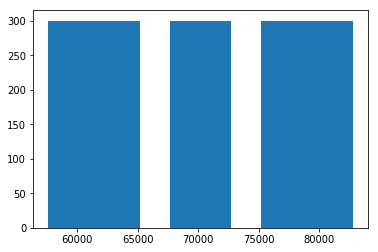

In [51]:
plt.hist(wait_times);plt.show()

## Implementing a Queue

As you saw earlier, 

### the average wait time is higher with a queue than with a stack. 

This is to be expected, given our scenario where the waiting time extends all the way to the next morning. However, many tasks just need to be processed in order, and don't have a condition that means you need to either return a result very quickly or very slowly. We'll explore the histogram of waiting times with queues more in the next screen.<br>

You should have also noticed that the wait times for queues go up as more tasks are added. The values towards the end of `wait_times` are much higher than the values towards the beginning. This reflects the fact that the length of the queue is increasing, so each additional task has to wait for more tasks to be processed before it can be run. A stack doesn't have this issue, since each new task is added to the top, and doesn't have to wait for the whole stack to be processed first.<br>

For now, let's work on implementing our own queue to improve our understanding. Similarly to implementing a stack, The easiest way to implement a queue is to create a custom class. The class needs two methods at the minimum:

In [ ]:
class Queue():
    def __init__(self):
        
        self.items = []
        
    def push(self, value):
        self.items.append(value)
        
    def pop(self):
        return self.items.pop(0)
    
    def count(self):
        return len(self.items)
    
    
queue = Queue()
queue.push(1)
queue.push(2)
queue.push(3)

queue.pop()

## Time Spent in Queues

When we were experimenting with stacks, we adjusted how we defined waiting time. This allowed us to base waiting time on the number of tasks executed before a given task. This gives us a more real-world look at how long tasks would take to execute than our specific DMV scenario of having people come back the next day.<br>

As you may recall, we used the formula `20 * applications_processed_while_waiting + 600` to compute the waiting time for a given application. We can keep track of the number of applications processed before an application by using a counter. We can do this by:
* Creating a list called `queue_time`.
* Appending a `0` to `queue_time` whenever a task is placed onto the queue. The task number of the task minus one is equal to the index of the task in `queue_time`. If we want to look up how many tasks have been processed before a given task, we look up `queue_time[task_number - 1]`.
* When a task is processed, look up its corresponding entry in `queue_time` to get the number of applications processed before it.
* When a task is processed, add `1` to every entry in `queue_time` to indicate the tasks that were processed before it.

In [58]:
queue, queue_times, wait_times = [], [], []

def add_tasks(sleep_time):
    for index, row in applications.iterrows():
        queue.append((index + 1, row))
        queue_times.append(0)
        time.sleep(sleep_time)

def process_tasks(sleep_time):
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(queue) == 0:
            time.sleep(sleep_time)
        else:
            task_number, application = queue.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            
            wait_times.append(queue_times[task_number - 1]*20+600)
            
            for i in range(len(queue_times)):
                queue_times[i] += 1
            
t1 = threading.Thread(target=add_tasks, args=(.001,))
t2 = threading.Thread(target=process_tasks, args=(1,))

t1.start()
t2.start()
for t in [t1,t2]:
    t.join()

average_wait_time = sum(wait_times) / 2400
print(average_wait_time)

6195.925


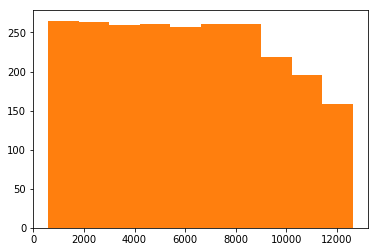

In [60]:
plt.hist(wait_times); plt.show()

In [56]:
test_times = [(.001, 10),
             (.001, 1),
             (.001, .1),
             (.001, .01)]

avg_wait_times = []

for tt in test_times:
    queue, queue_times, wait_times = [], [], []
    avg_wait_times.append(test_and_get_avg_time(tt[0], tt[1]))


add_task wait time: 0.001
process_tasks wait time: 10
AVG time: 24570.008333333335
add_task wait time: 0.001
process_tasks wait time: 1
AVG time: 6189.283333333334
add_task wait time: 0.001
process_tasks wait time: 0.1
AVG time: 1201.525
add_task wait time: 0.001
process_tasks wait time: 0.01
AVG time: 659.9416666666667


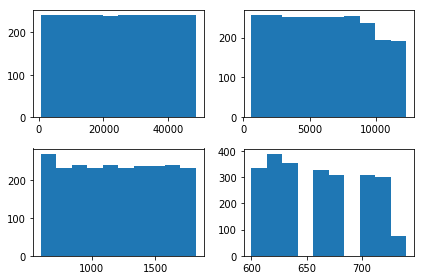

In [57]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.hist(avg_wait_times[0])

ax2 = fig.add_subplot(222)
ax2.hist(avg_wait_times[1])

ax3 = fig.add_subplot(223)
ax3.hist(avg_wait_times[2])

ax4 = fig.add_subplot(224)
ax4.hist(avg_wait_times[3])

plt.tight_layout()
fig = plt.gcf()
plt.show()

## Profiling Stacks As Elements Are Added

The average wait time using a queue wasn't extremely different from the average wait time when using a stack. However, the histogram of the queue times did look very different. Here's the histogram of wait times for the queue:

![hist-waits-queue](https://s3.amazonaws.com/dq-content/172/queue_wait_time_hist.png)

And here's the histogram of wait times using the stack:

![hist-waits-stack](https://s3.amazonaws.com/dq-content/172/wait_time_hist.png)

As you can tell from the above histograms, **queues have a much lower maximum wait time than stacks used in the same scenario**. As you may be able to tell from the histograms, queues:
* Are generally **best when you want all tasks processed at about the same pace**
* Have a fairly **low maximum wait time** for processing tasks

And stacks:
* Are generally **best when you want tasks processed very quickly if possible, but are okay waiting around for a while if not**.
* Have a fairly **high maximum wait time**.

What we haven't looked into as much so far is waiting time by position in the list of tasks. For example, is it better to be the `2200th` task added to a stack or to a queue? Which one will be processed first? We can answer this question by storing wait time by task number, then making a bar plot of how long it took to process each task number, in order.<br>

We can do this by initializing `wait_times` to have one element for each row in `applications`. Then, we can just store the wait time for a particular task at the position in `wait_times` whose index equals the task number minus one. This will give us a list, in order of when each application arrived, of how long each application took to process.<br>

We'll start by profiling a stack, then compare to a queue.

* Create a list called `wait_times`, with `2400` elements.
* Modify `process_tasks`:
  * Compute wait time based on the `20 * applications_processed_before + 600` formula.
  * Assign the wait time to the index corresponding to `task_number - 1` in wait_times.
* Run both threads like you did in an earlier screen.
* Plot a bar chart of `wait_times` using matplotlib.
  * The x-axis should be the task number.
* What can you tell about the wait times as the stack grows larger from the bar chart? Why do you think the pattern looks the way it does?

In [64]:
queue_times = []
wait_times = [0] * 2400
stack = []

def add_tasks():
    for index, row in applications.iterrows():
        stack.insert(0,(index + 1, row))
        queue_times.append(0)
        time.sleep(.001)
        
def process_tasks():
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(stack) == 0:
            time.sleep(1)
        else:
            task_number, application = stack.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            
            wait_time = queue_times[task_number - 1]*20+600
            wait_times[task_number - 1] = wait_time
            
            for i in range(len(queue_times)):
                queue_times[i] += 1
                
t1 = threading.Thread(target=add_tasks)
t2 = threading.Thread(target=process_tasks)

t1.start()
t2.start()
for t in [t1,t2]:
    t.join()


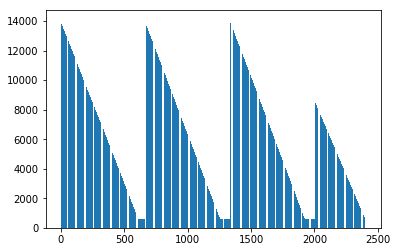

In [69]:
x = range(1, 2401)
plt.bar(x, wait_times);plt.show()

## Profiling Queues As Elements Are Added

As you should have seen in the last screen, the bar chart of time taken vs. position for a stack looks like this:

![barchart-vs-position-stack](https://s3.amazonaws.com/dq-content/172/stack_over_time.png)

The earlier elements kept getting pushed down the stack, and were only processed towards the end, so they had a much longer wait time. Tasks that came into the stack later were processed earlier, so had a much lower wait time. Many tasks were completed immediately, so had very little wait time. **From the bar chart, we can see that tasks are either processed immediately, or have to wait until everything ahead of them is processed**.<br>

Now that we know how each task that is added to the stack is processed, let's do the same thing for queues.

* Create a list called `wait_times`, with `2400` elements.
* Modify `process_tasks`:
  * Compute wait time based on the `20 * applications_processed_before + 600` formula.
  * Assign the wait time to the index corresponding to `task_number - 1` in `wait_times`.
* Run both threads like you did in an earlier screen.
* Plot a bar chart of `wait_times` using matplotlib.
  * The x-axis should be the task number.
* What can you tell about the wait times as the queue grows larger from the bar chart? Why do you think the pattern looks the way it does?

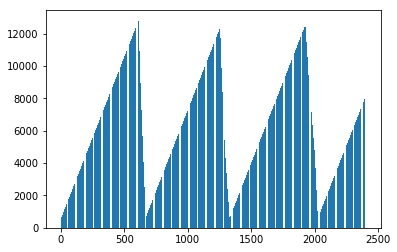

In [72]:
queue_times = []
wait_times = [0] * 2400
queue = []

def add_tasks():
    for index, row in applications.iterrows():
        queue.append((index + 1, row))
        queue_times.append(0)
        time.sleep(.001)

def process_tasks():
    tasks_finished = 0
    while tasks_finished < 2400:
        if len(queue) == 0:
            time.sleep(1)
        else:
            task_number, application = queue.pop(0)
            resp = process_application(application)
            tasks_finished += 1
            
            wait_times[task_number - 1] = 20*queue_times[task_number - 1]+600
            
            for i in range(len(queue_times)):
                queue_times[i] += 1

t1 = threading.Thread(target=add_tasks)
t2 = threading.Thread(target=process_tasks)

t1.start()
t2.start()
for t in [t1,t2]:
    t.join()
    
plt.bar(range(2400), wait_times);plt.show()

## Queues vs. Stacks

The bar chart for a queue in the last screen should have looked something like this:

![barchart-queue](https://s3.amazonaws.com/dq-content/172/queue_over_time.png)

This compares to the stack bar chart, which looked like this:

![barchart-stack](https://s3.amazonaws.com/dq-content/172/stack_over_time.png)

From these charts, we can make some conclusions about stacks and queues as we add more elements. For stacks:
* Items added to a stack towards the end are processed much faster than items added towards the beginning.
* Some stack tasks are finished almost immediately after they're added.
* The worst-case queue time in a stack is equivalent to waiting for every single task to be processed first.

On the other hand, for queues:
* Items added to a queue towards the end are processed more slowly than items added earlier (this depends strongly on the throughput of the task processor).
* Only the first item added to a queue is processed instantly (given that tasks are added faster than they can be processed).
* The worst-case queue time for a queue depends on the throughput of the task processor.

We can make **some generalizations** about stacks and queues for prioritizing tasks based on what we've learned:
* **Stacks are better for tasks where immediacy matters, but if older messages are delivered slowly, it doesn't matter**. One example is a **social network like Twitter** -- new tweets matter much more than older tweets, and showing them should be prioritized. Thus you'd want to process and show newer tweets faster if your system was overloaded, but could afford to ignore older ones for a while.
* **Queues are better for tasks where consistency matters**. An example is ordering delivery with a tool like [Seamless](https://www.seamless.com/). Seamless can't just ignore older orders, so they need to process everything with a queue to **ensure fairness**.

In the DMV example, a stack seems like a better choice for processing tasks, because of the use case -- we want some people to be able to immediately get their license, but everyone else has to wait until the next day. In general, deciding to use a stack or a queue to prioritize tasks strongly depends on the task itself. It's advisable to figure out the peformance characteristics of all the components, and the desired characteristics of the prioritization, before deciding whether to use a stack or a queue.<br>

In the next mission, we'll cover arrays and lists in more depth, and discuss how knowing which data structure you're using can dramatically speed up your analysis.